# Examples

In [1]:
import sys
sys.path.append('../')

In [2]:
from incontext import *

import os
from itertools import chain

In [3]:
toy_sample = {
    'repo': 'adaptive-code-completion',
    'completion_file': {
        'filename': None,
        'content': None,
    },
    'repo_snapshot': {
        'filename': [],
        'content': [],
    },
}

path_to_configs = '../configs'
path_to_evaluation = '../evaluation'
path_to_incontext = '../incontext'
path_to_pipeline = '../pipeline'

path_to_completion_file = '../incontext/__init__.py'

In [4]:
for directory, _, filenames in chain(*map(os.walk, (path_to_configs, path_to_evaluation, path_to_incontext, path_to_pipeline))):
    if '__pycache__' in directory:
        continue
    
    for filename in filenames:
        if filename == 'adaptive_code_completion.py':
            continue

        filename = os.path.join(directory, filename)

        with open(filename) as file:
            content = file.read()
        
        if filename == path_to_completion_file:
            toy_sample['completion_file']['filename'] = filename
            toy_sample['completion_file']['content'] = content
        else:
            toy_sample['repo_snapshot']['filename'].append(filename)
            toy_sample['repo_snapshot']['content'].append(content)

assert toy_sample['completion_file']['filename'] is not None

In [5]:
composer_kwargs = dict(
    pre_context_prompt='<repo_name>{}\n<file_sep>',
    post_context_prompt='<file_sep>',
    path_comment_template='# {filename}\n{content}',  # to format completion file
)
ocoder_assembler = PathCommentAssembler(chunks_sep='<file_sep>', path_comment_template='# {filename}\n{content}')

### File-Level Composer

In [6]:
composer = ChainedComposer([
    NullFileFilter(),
    FileGrainedChunker(),
    ocoder_assembler,
],
    **composer_kwargs,
)

In [7]:
# you can access the composer initialization code by using its __repr__
repr(composer)

"ChainedComposer([NullFileFilter(), FileGrainedChunker(), PathCommentAssembler(chunks_sep='<file_sep>', path_comment_template='# {filename}\n{content}')], pre_context_prompt='<repo_name>{}\n<file_sep>', post_context_prompt='<file_sep>', path_comment_template='# {filename}\n{content}')"

In [8]:
composed_sample = composer.compose(toy_sample)
composed_sample.keys()

dict_keys(['pre_context_prompt', 'composed_context', 'composed_completion'])

In [9]:
# repo identifier
composed_sample['pre_context_prompt']

'<repo_name>adaptive-code-completion\n<file_sep>'

In [10]:
# default way to compose a completion part
print(composed_sample['composed_completion'])

# ../incontext/__init__.py
# abstract base classes
from incontext.blocks.block import ComposerBlock
from incontext.composer.composer_base import ComposerBase

# abstract block types
from incontext.blocks.file_filtering import FileFilter
from incontext.blocks.file_preprocessing import FilePreprocessor
from incontext.blocks.file_chunking import FileChunker
from incontext.blocks.chunk_ranking import ChunkRanker
from incontext.blocks.chunk_sorting import ChunkSorter
from incontext.blocks.chunk_assembling import ChunkAssembler
from incontext.blocks.context_postprocessing import ContextPostprocessor

# blocks
from incontext.blocks.file_filtering import (
    NullFileFilter,
    InclusiveFileExtensionFilter,
    ExclusiveFileExtensionFilter,
    EmptyFileFilter,
    FileLengthFilter,
)
from incontext.blocks.file_preprocessing import (
    EmptyLinesRemovalPreprocessor,
    NewlinePreprocessor,
    DeclarationOnlyPreprocessor,
)
from incontext.blocks.file_chunking import (
    FileGrainedChunk

In [11]:
# empty context
print(composed_sample['composed_context'])

<file_sep>


### Path Distance `.py` Composer

In [12]:
composer = ChainedComposer([
    EmptyFileFilter(),
    InclusiveFileExtensionFilter(whitelist=['.py']),
    NewlinePreprocessor(),
    FileGrainedChunker(),
    NegativePathDistanceRanker(),
    IoURanker(min_len=5),
    LexicographicSorter(),
    ocoder_assembler,
],
    **composer_kwargs,
)

In [13]:
composed_sample = composer.compose(toy_sample)
print(composed_sample['composed_context'])

# ../pipeline/trainers/utils/schedulers.py
import math


def get_lr_from_cosine_scheduler_with_linear_warmup(iter_num: int,
                                                    min_lr: float,
                                                    max_lr: float,
                                                    warmup_iters: int,
                                                    lr_decay_iters: int,
                                                    ) -> float:
    if iter_num < warmup_iters:  # warmup
        return max_lr * (iter_num + 1) / warmup_iters
    elif iter_num > lr_decay_iters:  # constant lr
        return min_lr
    else:  # cosine wave
        decay_ratio = (iter_num - warmup_iters) / (lr_decay_iters - warmup_iters)
        return min_lr + (max_lr - min_lr) / 2 * (1 + math.cos(math.pi * decay_ratio))
<file_sep># ../pipeline/trainers/utils/fused_sampler.py
import math
from typing import Iterator

import torch
from torch.utils.data import Sampler


class FusedSampler(Samp

### Declaration `.py` Composer

In [14]:
# initialize from config file
composer = init_from_config('../configs/composer/declarations.yaml')
repr(composer)

"ChainedComposer(pre_context_prompt='<repo_name>{}\n<file_sep>', post_context_prompt='<file_sep>', path_comment_template='# {filename}\n{content}', blocks=[EmptyFileFilter(), InclusiveFileExtensionFilter(whitelist=['.py']), NewlinePreprocessor(), DeclarationOnlyPreprocessor(), FileGrainedChunker(), NegativePathDistanceRanker(), IoURanker(min_len=5), LexicographicSorter(), PathCommentAssembler(chunks_sep='<file_sep>', path_comment_template='# {filename}\n{content}')])"

In [15]:
composed_sample = composer.compose(toy_sample)
print(composed_sample['composed_context'])

# ../pipeline/trainers/utils/schedulers.py
def get_lr_from_cosine_scheduler_with_linear_warmup(iter_num: int,
                                                    min_lr: float,
                                                    max_lr: float,
                                                    warmup_iters: int,
                                                    lr_decay_iters: int,
                                                    ) -> float: ...<file_sep># ../pipeline/trainers/utils/fused_sampler.py
class FusedSampler(Sampler[int]): ...
    def __init__(self,
                 start_sample_idx: int,
                 end_sample_idx: int,
                 dataset_length: int,
                 generator: torch.Generator | None = None,
                 ) -> None: ...
    def __iter__(self) -> Iterator[int]: ...
    def __len__(self) -> int: ...<file_sep># ../pipeline/model/adapters/adapter_base.py
class AdapterBase(ABC): ...
    def __init__(self, model_name: str, params_pattern: str 

# Base Composer

In general, a composer constructs a new _composed_ data point from the raw one. For this purpuse, it devides the data into four main parts:

1. Leading prompt, `get_pre_context_prompt` method.
2. Composed context, `compose_context` method.
3. Prompt following context, `get_post_context_prompt` method.
4. Composed completion, `compose_completion` method.

In the simplest case, the leading prompt could be an empty string or the repository identifier, and the post-context prompt could be just a separator between the two main parts — context and completion. Now, let's focus on how we can compose context. 

# Chained Composer

A more general approach is to inherit from `ComposerBase` class and implement the corresponding method. It is a quick but not scalable solution in terms of efficient search space exploration. That's why we propose a more robust way of defining the composition pipeline — a chain of individual blocks.

Types of such blocks:

1. `FileFilter`, **file_filtering** module.
2. `FilePreprocessor`, **file_preprocessing** module.
3. `FileChunker`, **file_chunking** module.
4. `ChunkRanker`, **chunk_ranking** module.
5. `ChunkSorter`, **chunk_sorting** module.
6. `ChunkAssembler`, **chunk_assembling** module.
7. `ContextPostprocessor`, **context_postprocessing** module.

See below for more details.

The next directed graph illustrates:

- The available order of blocks,
- How optional their use is (the bold subgraph indicates optionality),
- Data structure transitions: **Files -> Chunks -> Context** (grey frames).

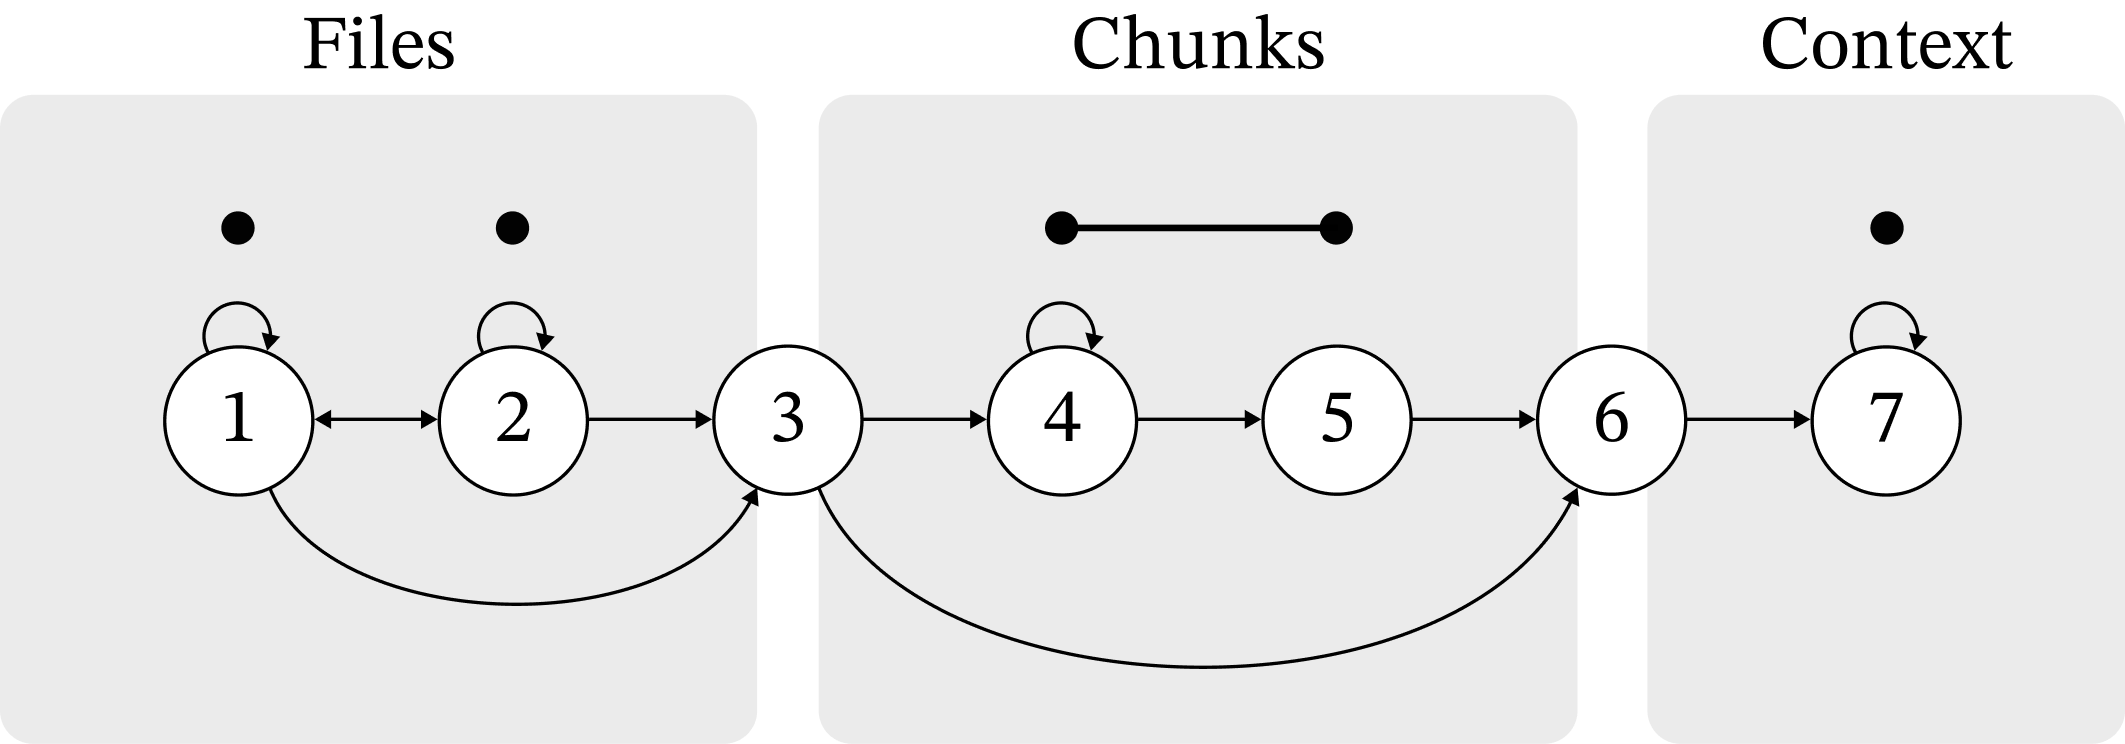

In [16]:
from PIL import Image
Image.open('composer-blocks.png')

## file_filtering

**Abstract class**: `FileFilter`. \
**Purpose**: Filter out unwanted files. \
**Currently implemented**:

- `NullFileFilter` removes all context files,
- `InclusiveFileExtensionFilter` selects files by their extensions,
- `ExclusiveFileExtensionFilter` removes files by their extensions,
- `EmptyFileFilter` removes empty files,
- `FileLengthFilter` removes files that are too short or long (at the character level),

## file_preprocessing

**Abstract class**: `FilePreprocessor`. \
**Purpose**: File-level content modification. \
**Currently implemented**:

- `EmptyLinesRemovalPreprocessor` removes empty lines,
- `NewlinePreprocessor` normalizes newlines,
- `DeclarationOnlyPreprocessor` extracts function and class declarations.

## file_chunking

**Abstract class**: `FileChunker`. \
**Purpose**: Convert a set of files into chunks, change granularity. \
**Currently implemented**:

- `FileGrainedChunker` assigns a one-to-one relationship (can be understood as _no chunking_),
- `CodeSegmentGrainedChunker` splits one Python file into four blocks: imports, docstrings, ≥3 lines comments, and code,
- `DocstringAndCommentOnlyChunker` extracts docstring and comment chunks from the file,
- `CodeOnlyChunker` extracts code snippets from the file,
- `FixedLineChunker` splits the file into overlapping chunks,
- `CompletionDuplicationChunker` replaces the repository context with the completion file.

## chunk_ranking

**Abstract class**: `ChunkRanker`. \
**Purpose**: Determine the importance of a chunk. \
**Currently implemented**:

- `NegativePathDistanceRanker` based on the same idea as presented in the LCA paper,
- `FileExtensionRanker` prioritizes some extensions over others,
- `FunctionCallRanker` prioritizes chunks with a higher number of function calls,
- `RandomRanker` shuffles chunks,
- `IoURanker` prioritizes files with a larger number of shared lines with the completion file.

## chunk_sorting

**Abstract class**: `ChunkSorter`. \
**Purpose**: Sort a set of chunks based on their ranks. \
**Currently implemented**:

- `LexicographicSorter` preserves rankers order,
- `ReverseLexicographicSorter` creates irrelevant context,
- `MixedSorter` interleaves rankers for ordering.

## chunk_assembling

**Abstract class**: `ChunkAssembler`. \
**Purpose**: Join sorted chunks. \
**Currently implemented**:

- `JoiningAssembler` uses the provided string as a separator,
- `PathCommentAssembler` adds information about the file's position in the project.

## context_postprocessing

**Abstract class**: `ContextPostprocessor`. \
**Purpose**: Context-level content modification. \
**Currently implemented**:

- `PartialMemoryPostprocessor` drops some lines with a given probability,
- `LineLengthPostprocessor` removes lines that are too short or long,
- `LineStripPostprocessor` strips lines,
- `CompletionLeakPostprocessor` leaks chunks of the completion file into the repository context,
- `ReversedContextPostprocessor` applies the reversal of the context files that fall into the context window of the model,
- `RandomTokensPostprocessor` replaces the context with a decoded sequence of random, non-special tokens.